# STAT 538A Final Project
Grace Yin (48450150)

# Generalized Linear Models for Predicting Human Suicide Numbers
## Mental health and Human Rights

  Suicide has become a serious problem worldwide. However, due to the widespread stigmatizations associated with mental health problems and suicide per se, it is hard to predict the exact number of people committing suicide. Thereby, in this project, I developed a Generalized Linear Model (GLM), combined with its extension versions, including the Generalized Linear Mixed Model (GLMM) and Negative Binomial Regression (NB2), to make more accurate predictions of suicidal numbers. I also discussed the limitation of  these models.

This project contains four main contents: (1) First, I will briefly introduce the dataset I used from the WHO Statistics and discuss the response variables and covariates. (2) Secondly, I will do exploratory data analysis with this dataset. Data visualization is also included. (3) Then I will analyze the models I fitted for the prediction of suicide numbers, including Poisson regression, GLMM, and Negative Binomial Regression. (4) I will do some discussion on the results and limitation of these models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import scipy.stats as stats
from scipy.special import gammaln
matplotlib.rcParams['font.size'] = 18
import seaborn as sns
import statsmodels.formula.api as smf

Suicide is violence and mental health problem worldwide. The World Health Organization (WHO) estimated that around 800 000 people die due to suicide every year, which is one person every 40 seconds. Suicide is a global phenomenon and occurs throughout the lifespan. Therefore, I am interested in predicting the suicide numbers to improve suicide prevention system.

In [2]:
# Load Dataset
data = pd.read_csv('master.csv')
data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
#print data size
np.shape(data)

(27820, 12)

### Scatter Plots

Text(0.5, 1.0, 'Scatter Plot of gdp_per_capita with suicide numbers')

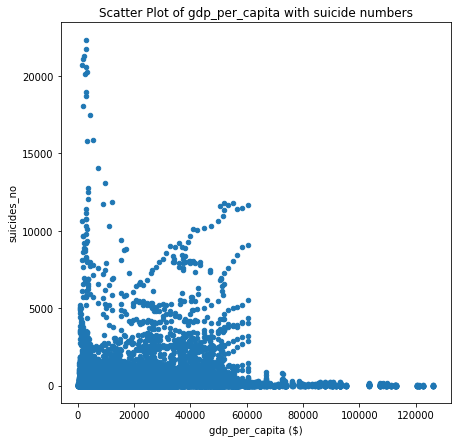

In [4]:
data.plot.scatter(x='gdp_per_capita ($)', y='suicides_no', figsize=(7,7))
plt.title('Scatter Plot of gdp_per_capita with suicide numbers')

Text(0.5, 1.0, 'Scatter Plot of gdp_per_capita with suicide numbers')

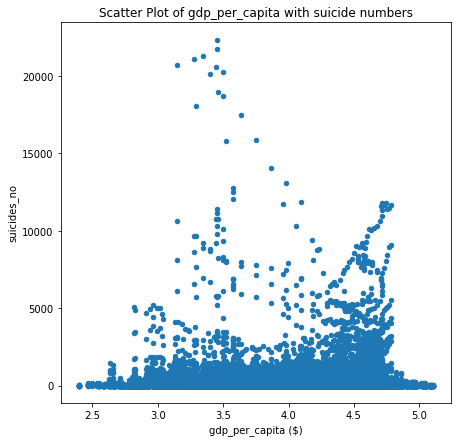

In [5]:
#log-transformation
data['gdp_per_capita ($)'] = np.log10(data['gdp_per_capita ($)'])
data.plot.scatter(x='gdp_per_capita ($)', y='suicides_no', figsize=(7,7))
plt.title('Scatter Plot of gdp_per_capita with suicide numbers')

## Data Visualization

Before fitting GLM models, I conducted some data visualization to generate some conclusive statistics.

Text(0.5, 0, 'total number')

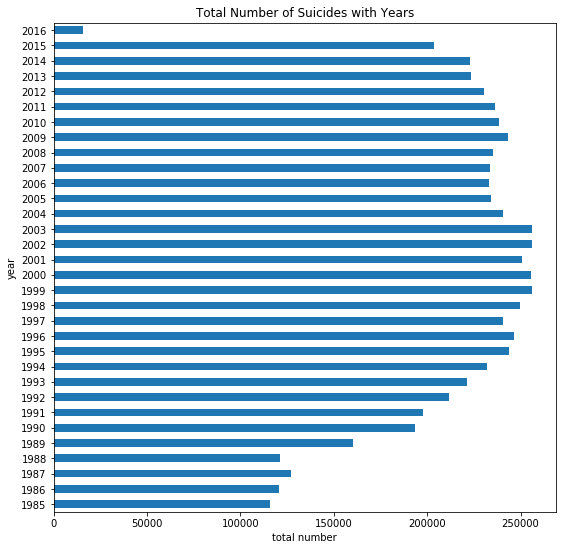

In [6]:
data.groupby(['year']).suicides_no.sum().plot(kind='barh',figsize=(9,9))
plt.title('Total Number of Suicides with Years')
plt.xlabel('total number')

Text(0.5, 0, 'total number')

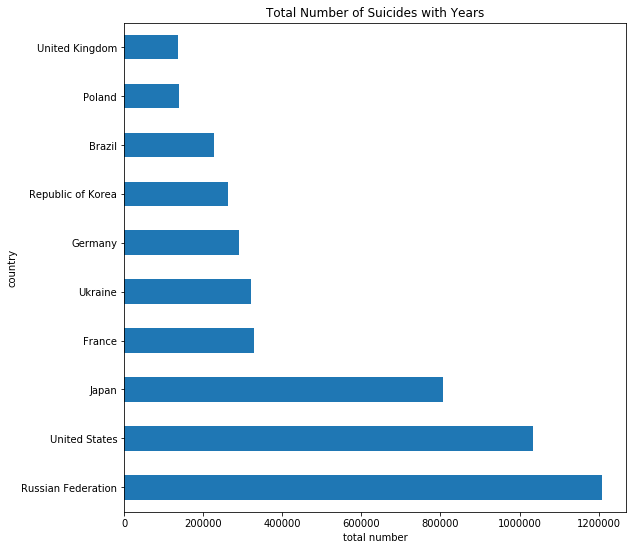

In [7]:
data.groupby(['country']).suicides_no.sum().nlargest(10).plot(kind='barh',figsize=(9,9))
plt.title('Total Number of Suicides with Years')
plt.xlabel('total number')

Text(0.5, 1.0, 'Total Number of Suicides with Age')

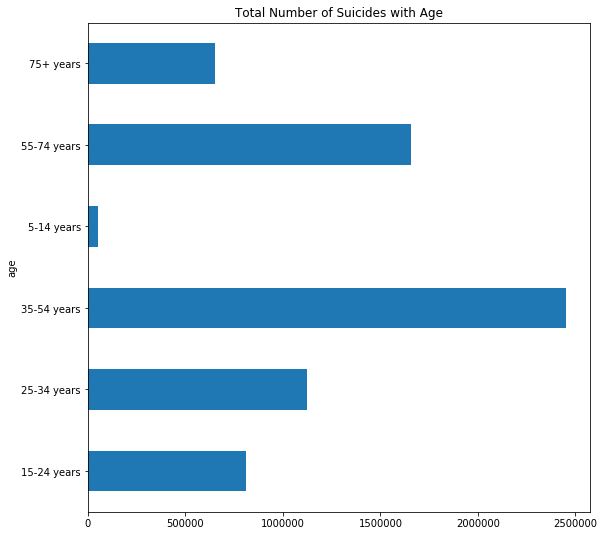

In [8]:
data.groupby(['age']).suicides_no.sum().plot(kind='barh',figsize=(9,9))
plt.title('Total Number of Suicides with Age')

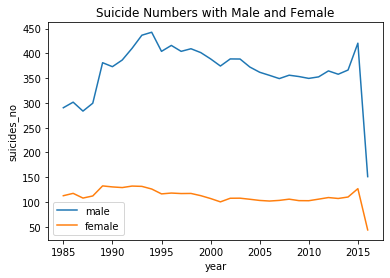

In [9]:
df_men = data[data.sex == "male"]
df_women = data[data.sex == "female"]
sns.lineplot(df_men.year, data.suicides_no, ci = None).set_title('Suicide Numbers with Male and Female')
sns.lineplot(df_women.year, data.suicides_no, ci = None)
plt.legend(["male", 'female'])
plt.show()
sns.set(rc={'figure.figsize':(10,10)})

Since there is no conspicuous fluctuation of the total number of suicides from 1995 to 2015, to simplify the process, I extract the dataset from 2013 to 2015, and split them into training dataset and test dataset randomly with ratio 7:3.

In [10]:
data_2013 = data[data['year']==2013]
data_2014 = data[data['year']==2014]
data_2015 = data[data['year']==2015]
new_data = pd.concat([data_2013,data_2014,data_2015])
new_data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
552,Antigua and Barbuda,2013,female,15-24 years,0,8494,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Millenials
553,Antigua and Barbuda,2013,female,25-34 years,0,7397,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Millenials
554,Antigua and Barbuda,2013,female,35-54 years,0,15236,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Generation X
555,Antigua and Barbuda,2013,female,5-14 years,0,8353,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Generation Z
556,Antigua and Barbuda,2013,female,55-74 years,0,5787,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Boomers


In [11]:
# print the data size for new_data
np.shape(new_data)

(2640, 12)

In [12]:
#check missing values
new_data.isnull().sum()

country                 0
year                    0
sex                     0
age                     0
suicides_no             0
population              0
suicides/100k pop       0
country-year            0
HDI for year          816
 gdp_for_year ($)       0
gdp_per_capita ($)      0
generation              0
dtype: int64

The HDI for year will not be used because there are many missing values in this column, and there is no accurate way to impute so many missing values due to the lack of information.

# Fit GLM 

In [13]:
new_data = new_data.copy()
# add intercept
new_data["Intercept"] = 1
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#binary transformation
new_data.sex = le.fit_transform(new_data.sex) # female:0 , male:1
#age data transformation
new_data.age = le.fit_transform(new_data.age)
new_data['gdp_per_capita ($)2']=(new_data['gdp_per_capita ($)'])
np.random.seed(1)
#split dataset to training data and test data
train_mask = np.random.rand(new_data.shape[0]) > .3
data_test = new_data[~train_mask]
new_data = new_data[train_mask]

In [14]:
new_data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation,Intercept,gdp_per_capita ($)2
552,Antigua and Barbuda,2013,0,0,0,8494,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Millenials,1,4.123427
553,Antigua and Barbuda,2013,0,1,0,7397,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Millenials,1,4.123427
555,Antigua and Barbuda,2013,0,3,0,8353,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Generation Z,1,4.123427
559,Antigua and Barbuda,2013,1,1,0,6782,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Millenials,1,4.123427
560,Antigua and Barbuda,2013,1,2,0,13302,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Generation X,1,4.123427


In [15]:
np.shape(new_data)

(1846, 14)

In [16]:
np.shape(data_test)

(794, 14)

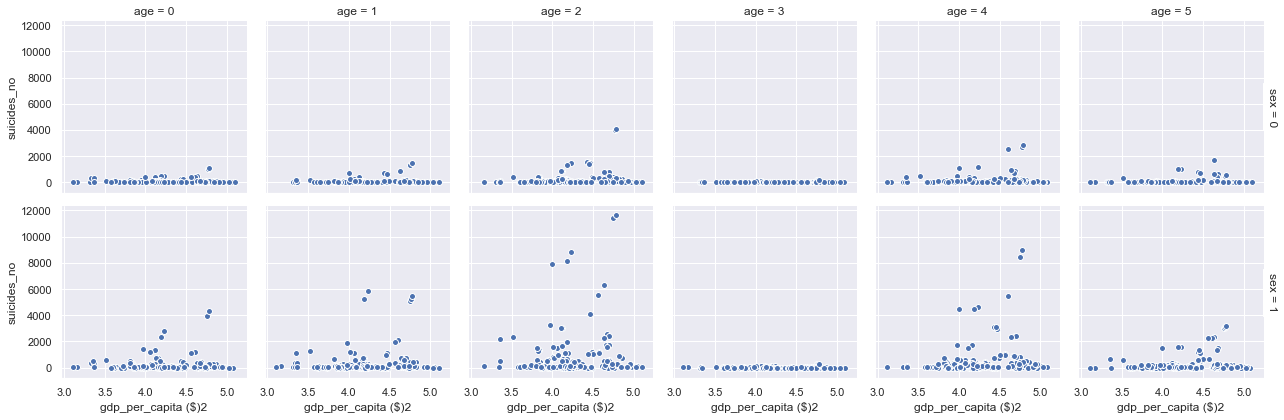

In [17]:
# scatter plots for conditional relationships
g = sns.FacetGrid(new_data, row="sex", col="age", margin_titles=True)
g.map(plt.scatter, "gdp_per_capita ($)2","suicides_no", edgecolor="w")

### Simple Poisson Regression

In [18]:
model1 = sm.Poisson(endog =new_data['suicides_no'], exog = sm.add_constant(new_data[['sex','age','gdp_per_capita ($)2']]))
res1 = model1.fit()

Optimization terminated successfully.
         Current function value: 367.597865
         Iterations 6


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [19]:
poisson1 = sm.GLM(new_data['suicides_no'], sm.add_constant(new_data[['sex','age','gdp_per_capita ($)2']]), family=sm.families.Poisson()).fit()
print(poisson1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            suicides_no   No. Observations:                 1846
Model:                            GLM   Df Residuals:                     1842
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -6.7859e+05
Date:                Tue, 08 Dec 2020   Deviance:                   1.3482e+06
Time:                        16:21:19   Pearson chi2:                 3.29e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1954    

In [20]:
#compute MSPE
y_pred1 = res1.predict(data_test[['sex','age','Intercept','gdp_per_capita ($)2']])
mspe1 = np.mean((y_pred1-data_test['suicides_no'])**2)
print(mspe1)

743061931.7387483


### GLMM

In [21]:
def log_trans(data):
    D = np.shape(new_data)[0]
    x = np.zeros(D)
    suicide =[]
    for i in (data['suicides_no'].index):
        if data['suicides_no'][i] == 0:
            suicide.append(0)
        else:
            suicide.append(np.log(data['suicides_no'][i]))
    return suicide   

In [22]:
#rename the columns
new_data['suicides_no'] = new_data['suicides_no'].astype(float)
new_data['gdp']=new_data["gdp_per_capita ($)2"]
data_test['gdp']=data_test["gdp_per_capita ($)2"]
#do log transformation

new_data['suicides_no2']=log_trans(new_data)

In [23]:
new_data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation,Intercept,gdp_per_capita ($)2,gdp,suicides_no2
552,Antigua and Barbuda,2013,0,0,0.0,8494,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Millenials,1,4.123427,4.123427,0.0
553,Antigua and Barbuda,2013,0,1,0.0,7397,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Millenials,1,4.123427,4.123427,0.0
555,Antigua and Barbuda,2013,0,3,0.0,8353,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Generation Z,1,4.123427,4.123427,0.0
559,Antigua and Barbuda,2013,1,1,0.0,6782,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Millenials,1,4.123427,4.123427,0.0
560,Antigua and Barbuda,2013,1,2,0.0,13302,0.0,Antigua and Barbuda2013,0.781,"1,192,925,407",4.123427,Generation X,1,4.123427,4.123427,0.0


### Simple Linear Regression

In [24]:
md1 = sm.OLS(endog = new_data['suicides_no2'], exog = sm.add_constant(new_data[['sex','age','gdp']]))
mdf1 = md1.fit()
print(mdf1.summary())

                            OLS Regression Results                            
Dep. Variable:           suicides_no2   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     47.16
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           2.32e-29
Time:                        16:21:20   Log-Likelihood:                -4083.4
No. Observations:                1846   AIC:                             8175.
Df Residuals:                    1842   BIC:                             8197.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0580      0.525      2.014      0.0

### GLMM Regression

In [25]:
md2 = smf.mixedlm("suicides_no2 ~  sex +age + gdp", new_data, groups=new_data["country"])
mdf2 = md2.fit()
print(mdf2.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: suicides_no2
No. Observations: 1846    Method:             REML        
No. Groups:       83      Scale:              1.6594      
Min. group size:  5       Likelihood:         -3246.9069  
Max. group size:  31      Converged:          Yes         
Mean group size:  22.2                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    1.628     1.837   0.887  0.375  -1.972   5.228
sex          1.026     0.061  16.951  0.000   0.907   1.144
age         -0.086     0.018  -4.877  0.000  -0.120  -0.051
gdp          0.293     0.431   0.680  0.497  -0.551   1.137
Group Var    3.348     0.428                               



In [26]:
data_test['suicides_no2']=log_trans(data_test)

In [27]:
#compute MSPE for these two models
y_pred1 = mdf1.predict(data_test[['sex','age','Intercept','gdp']])
y_pred2 = mdf2.predict(data_test[['sex','age','Intercept','gdp']])
mspe2=np.mean((y_pred1-data_test['suicides_no2'])**2)
mspe2=np.mean((y_pred2-data_test['suicides_no2'])**2)
print(mspe1)
print(mspe2)

743061931.7387483
4.970665409764749


### Negative Binomial Regression

In [28]:
#extract dataset for Russia
new_data = new_data.copy()
RUSSIA_train = new_data[new_data['country']=='Russian Federation']
RUSSIA_test = data_test[data_test['country']=='Russian Federation']

In [29]:
#Simple Poisson Regression
model1 = sm.Poisson(endog =RUSSIA_train['suicides_no'], exog = sm.add_constant(RUSSIA_train[['sex','age','gdp_per_capita ($)2']]))
res1 = model1.fit()
print(res1.summary())

Optimization terminated successfully.
         Current function value: 649.839547
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:            suicides_no   No. Observations:                   25
Model:                        Poisson   Df Residuals:                       21
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                  0.4441
Time:                        16:21:23   Log-Likelihood:                -16246.
converged:                       True   LL-Null:                       -29223.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.5438      0.182     57.897      0.000      10.187      10.901


In [30]:
res = sm.GLM(RUSSIA_train['suicides_no'], sm.add_constant(RUSSIA_train[['sex','age','gdp_per_capita ($)2']]), family=sm.families.Poisson()).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            suicides_no   No. Observations:                   25
Model:                            GLM   Df Residuals:                       21
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16246.
Date:                Tue, 08 Dec 2020   Deviance:                       32262.
Time:                        16:21:23   Pearson chi2:                 2.78e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.5438    

### Fit NB2
#### Code Reference:  Sachin Date in his towards data science blog:https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

In [31]:
# Compute alpha
RUSSIA_train=RUSSIA_train.copy()
RUSSIA_train['lambda1'] = res.mu
RUSSIA_train['AUX_OLS_DEP'] = RUSSIA_train.apply(lambda x: ((x['suicides_no'] - x['lambda1'])**2 - x['lambda1']) / x['lambda1'], axis=1)
ols_expr = """AUX_OLS_DEP ~ lambda1 - 1"""
aux_olsr_results = smf.ols(ols_expr, RUSSIA_train).fit()
print(aux_olsr_results.params)
# Fit NB2
res2= sm.GLM(RUSSIA_train['suicides_no'], RUSSIA_train[['sex','age','gdp_per_capita ($)2']],family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(res2.summary())

lambda1    0.409109
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:            suicides_no   No. Observations:                   25
Model:                            GLM   Df Residuals:                       22
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -218.00
Date:                Tue, 08 Dec 2020   Deviance:                       43.085
Time:                        16:21:25   Pearson chi2:                     22.6
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [32]:
y_pred1 = res1.predict(RUSSIA_test[['sex','age','gdp']])
mspe1=np.mean((y_pred1-RUSSIA_test['suicides_no'])**2)
y_pred2 = res2.predict(RUSSIA_test[['sex','age','gdp']])
mspe2=np.mean((y_pred2-RUSSIA_test['suicides_no'])**2)
print(mspe1)
print(mspe2)

623424113368.5658
1521442.023005291


### Diagnostic Plot

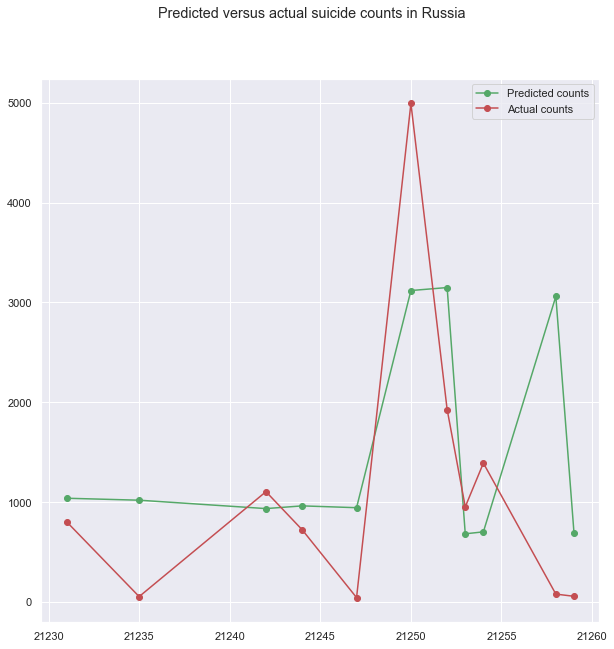

In [33]:
predicted_counts=y_pred2
actual_counts = RUSSIA_test['suicides_no']
fig = plt.figure()
fig.suptitle('Predicted versus actual suicide counts in Russia')
predicted, = plt.plot(RUSSIA_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(RUSSIA_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()